## Exploratory Data Analysis
## Table of Contents:
* [0. Importing dependencies](#dependencies)
* [1. Setting up of the dataset](#1.0)
    * [1.1 Importing dataset](#1.1)
    * [1.2 Outliners](#1.2)
* [2. Exploratory Data Analysis](#2.0)
    * [2.1 Trends and Seasonality ](#2.1)
    * [2.2 Correlation matrix](#2.2)

# 0. Importing dependencies  <a class="anchor" id="dependencies"></a>

In [8]:
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns

# 1. Setting up of the dataset <a class="anchor" id="1.0"></a>

## 1.1 Importing dataset <a class="anchor" id="1.1"></a>

In [2]:
# Load minute-based data and day-based data

# videoConsumption and impression
df_minute = pd.read_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_minute_Star_TV.csv')

# uniqueDevice
df_day = pd.read_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_ud_Star_TV.csv')

In [3]:
df_minute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797760 entries, 0 to 797759
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   datetime          797760 non-null  object
 1   videoConsumption  797760 non-null  int64 
 2   impression        797760 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 18.3+ MB


In [4]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          554 non-null    object
 1   uniqueDevice  554 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


In [5]:
# Data cleaning to remove missing values
df_minute = df_minute[(df_minute['videoConsumption'] != 0) & (df_minute['impression'] != 0)]
df_day = df_day[df_day['uniqueDevice'] != 0]

In [6]:
df_minute.describe()

,videoConsumption,impression
count,795317.000000,795317.000000
mean,49297.699026,1898.653690
std,78439.104986,2128.152006
min,3.000000,1.000000
25%,13685.000000,558.000000
50%,31004.000000,1403.000000
75%,54732.000000,2428.000000
max,983509.000000,94024.000000


In [7]:
df_day.describe()

,uniqueDevice
count,5.540000e+02
mean,9.666680e+05
std,2.273625e+05
min,2.268380e+05
25%,8.319100e+05
50%,9.515145e+05
75%,1.129101e+06
max,1.518805e+06


Average Active TV (aka video consumption): It's the average number of TVs that are currently tuned in to the TV channel each minute. (Admongrel takes a measurement every 30 second and averages it for the minute)

Impressions: It's the total number of TVs that tuned into the TV channel in the last minute. (Admongrel measures the number of channels that tuned into the channel in the past 30 seconds, and sums the two measurements for each minute)

Unique Household: The total number of unique TV households we measured each day that tuned into that specific channel. (We technically measure total distinct tv ip's/useragents, so technically the number of households will be slightly less than our measurement. This is because some households may have 2 or more TV's that we measure, but it's a close enough approximation)

## 1.2 Outliners <a class="anchor" id="1.2"></a>

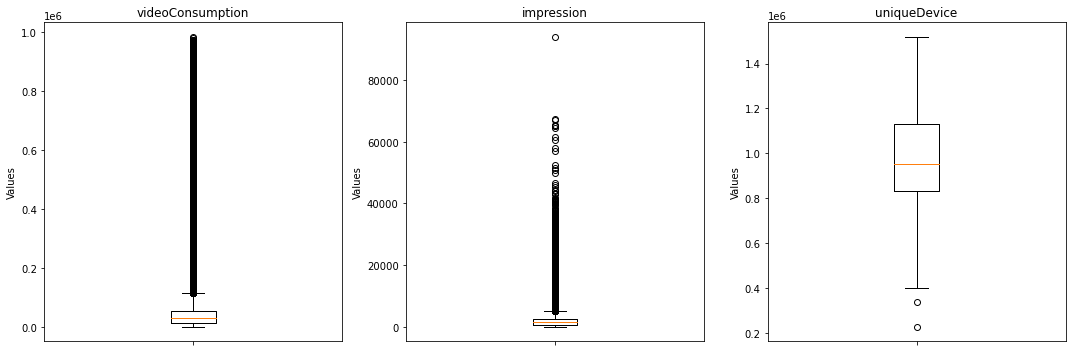

In [8]:
# Plot boxplot to see data distribution and anomalies
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

axs[0].boxplot(df_minute['videoConsumption'].dropna())
axs[0].set_title('videoConsumption')
axs[0].set_ylabel('Values')

axs[1].boxplot(df_minute['impression'].dropna())
axs[1].set_title('impression')
axs[1].set_ylabel('Values')

axs[2].boxplot(df_day['uniqueDevice'].dropna())
axs[2].set_title('uniqueDevice')
axs[2].set_ylabel('Values')

for ax in axs:
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

In [9]:
# Define variables for two data frame
variables_minute = ['videoConsumption', 'impression']
variables_day = ['uniqueDevice']

outlier_minute = []
outlier_day = []

# For df_minute
for var in variables_minute:
    Q1 = df_minute[var].quantile(0.25)
    Q3 = df_minute[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_minute[(df_minute[var] < lower_bound) | (df_minute[var] > upper_bound)].index
    outlier_minute.extend([element for element in outliers if element not in outlier_minute])
    print("Number of outliers in", var, ":", len(outliers), "out of", df_minute.shape[0])

# For df_day
for var in variables_day:
    Q1 = df_day[var].quantile(0.25)
    Q3 = df_day[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_day[(df_day[var] < lower_bound) | (df_day[var] > upper_bound)].index
    outlier_day.extend([element for element in outliers if element not in outlier_day])
    print("Number of outliers in", var, ":", len(outliers), "out of", df_day.shape[0])

# # Drop outliners
# df_minute_final = df_minute.drop(outlier_minute)
# df_day_final = df_day.drop(outlier_day)


Number of outliers in videoConsumption : 53641 out of 795317
Number of outliers in impression : 45431 out of 795317
Number of outliers in uniqueDevice : 2 out of 554


 Outliner%: videoConsumption 6.7%, impression 5.7%, uniqueDevice 0.4%, all of three are within the range of 10%. 


# 2. Exploratory Data Analysis  <a class="anchor" id="2.0"></a>

## 2.1 Trends and Seasonality <a class="anchor" id="2.4"></a>

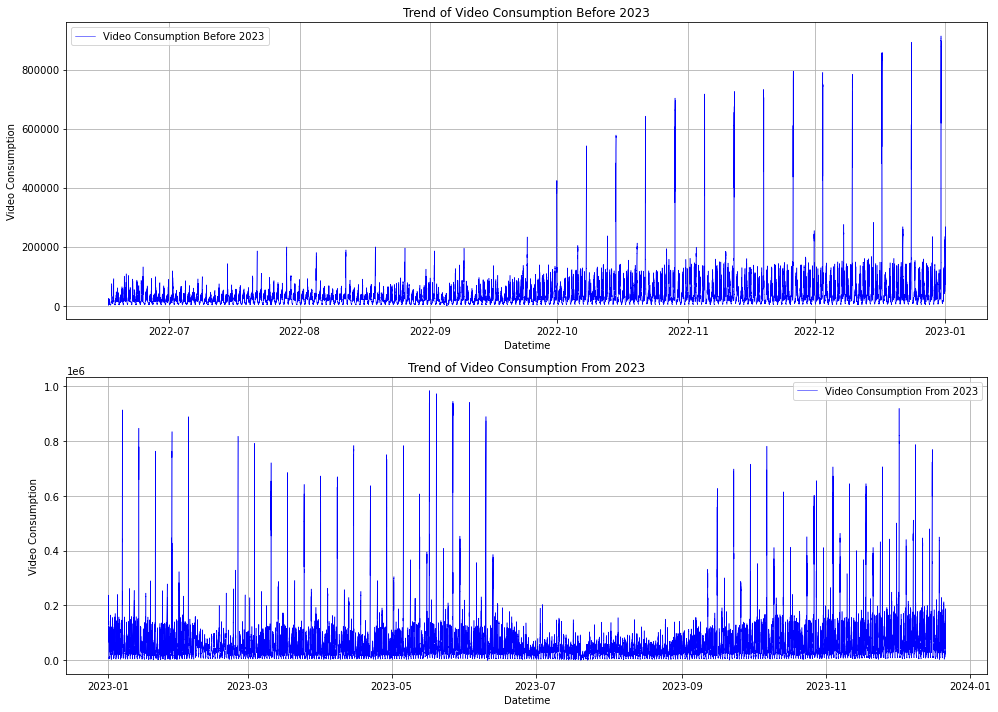

In [26]:
# Plot the trend of videoConsumption
# Convert datetime columns to datetime type
df_minute['datetime'] = pd.to_datetime(df_minute['datetime'])

# Define the split date for separating the plots
split_date = pd.to_datetime('2023-01-01')

# Set up the figure size and layout
plt.figure(figsize=(14, 10))

# Define line width for finer appearance
line_width = 0.5

# First subplot: data before the split date
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(df_minute[df_minute['datetime'] < split_date]['datetime'], 
         df_minute[df_minute['datetime'] < split_date]['videoConsumption'], 
         label='Video Consumption Before 2023', 
         linewidth=line_width, 
         color='blue')
plt.title('Trend of Video Consumption Before 2023')
plt.xlabel('Datetime')
plt.ylabel('Video Consumption')
plt.grid(True)
plt.legend()

# Second subplot: data from the split date onwards
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(df_minute[df_minute['datetime'] >= split_date]['datetime'], 
         df_minute[df_minute['datetime'] >= split_date]['videoConsumption'], 
         label='Video Consumption From 2023', 
         linewidth=line_width, 
         color='blue')
plt.title('Trend of Video Consumption From 2023')
plt.xlabel('Datetime')
plt.ylabel('Video Consumption')
plt.grid(True)
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

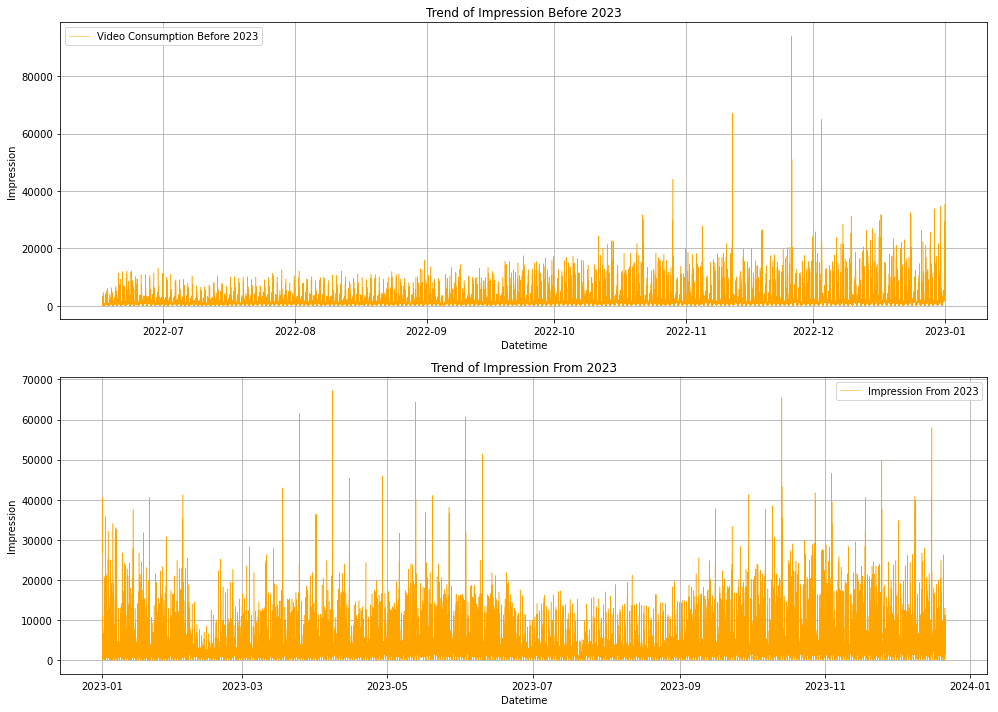

In [27]:
# Plot the trend of impression
# Convert datetime columns to datetime type
df_minute['datetime'] = pd.to_datetime(df_minute['datetime'])

# Define the split date for separating the plots
split_date = pd.to_datetime('2023-01-01')

# Set up the figure size and layout
plt.figure(figsize=(14, 10))

# Define line width for finer appearance
line_width = 0.5

# First subplot: data before the split date
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(df_minute[df_minute['datetime'] < split_date]['datetime'], 
         df_minute[df_minute['datetime'] < split_date]['impression'], 
         label='Video Consumption Before 2023', 
         linewidth=line_width, 
         color='orange')
plt.title('Trend of Impression Before 2023')
plt.xlabel('Datetime')
plt.ylabel('Impression')
plt.grid(True)
plt.legend()

# Second subplot: data from the split date onwards
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(df_minute[df_minute['datetime'] >= split_date]['datetime'], 
         df_minute[df_minute['datetime'] >= split_date]['impression'], 
         label='Impression From 2023', 
         linewidth=line_width, 
         color='orange')
plt.title('Trend of Impression From 2023')
plt.xlabel('Datetime')
plt.ylabel('Impression')
plt.grid(True)
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

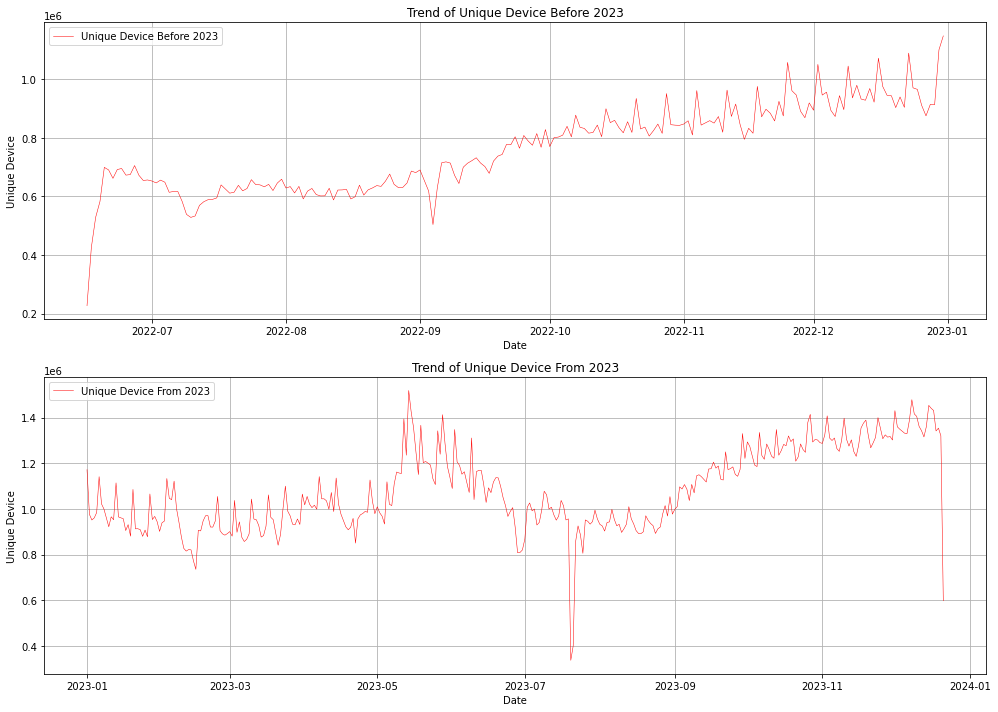

In [28]:
# Convert the date column to date type
df_day['date'] = pd.to_datetime(df_day['date'])

# Define the split date for separating the plots
split_date = pd.to_datetime('2023-01-01')

# Set up the figure size and layout
plt.figure(figsize=(14, 10))

# Define line width for finer appearance
line_width = 0.5

# First subplot: data before the split date
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(df_day[df_day['date'] < split_date]['date'], 
         df_day[df_day['date'] < split_date]['uniqueDevice'], 
         label='Unique Device Before 2023', 
         linewidth=line_width, 
         color='red')
plt.title('Trend of Unique Device Before 2023')
plt.xlabel('Date')
plt.ylabel('Unique Device')
plt.grid(True)
plt.legend()

# Second subplot: data from the split date onwards
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(df_day[df_day['date'] >= split_date]['date'], 
         df_day[df_day['date'] >= split_date]['uniqueDevice'], 
         label='Unique Device From 2023', 
         linewidth=line_width, 
         color='red')
plt.title('Trend of Unique Device From 2023')
plt.xlabel('Date')
plt.ylabel('Unique Device')
plt.grid(True)
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Only data from 2023 onwards will be retained for model applicability testing.

In [5]:
# Keep only data from 2023

# Convert the date column to date type
df_minute['datetime'] = pd.to_datetime(df_minute['datetime'])
df_day['date'] = pd.to_datetime(df_day['date'])

# Apply time filter
df_minute_final = df_minute[df_minute['datetime'] >= '2023-01-01']
df_day_final = df_day[df_day['date'] >= '2023-01-01']

In [7]:
## Plot tends，seasonality and residuals
def plot_seasonal(variable, df, freq):
    # Set up the subplots
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(25, 15))  

    # Extract the time series data for the current variable
    ts = df[variable]
    
    # Resample to daily data if the frequency is 'minute'
    if freq == 'minute':
        ts = ts.resample('D').mean()

    # Determine the period based on frequency for weekly and monthly trends
    period_weekly = 7  # one week in days
    period_monthly = 30  # approx. one month in days
    
    # Perform seasonal decomposition for weekly and monthly trend
    weekly_decomposition = seasonal_decompose(ts, period=period_weekly, model='additive')
    monthly_decomposition = seasonal_decompose(ts, period=period_monthly, model='additive')

    # Access the decomposition components
    weekly_trend = weekly_decomposition.trend # Represents smooth long-term changes in the data.
    monthly_trend = monthly_decomposition.trend # Represents smooth long-term changes in the data.
    seasonal = monthly_decomposition.seasonal # Represents a repeating pattern of fluctuations over a fixed period of time.
    residuals = monthly_decomposition.resid  

    # Plot the components in the subplots
    axs[0].plot(weekly_trend, label='Weekly Trend')
    axs[1].plot(monthly_trend, label='Monthly Trend')
    axs[2].plot(seasonal, label='Seasonal')
    axs[3].plot(residuals, label='Residuals')  

    # Set titles for each subplot
    axs[0].set_title(f"{variable} - Weekly Trend")
    axs[1].set_title(f"{variable} - Monthly Trend")
    axs[2].set_title(f"{variable} - Seasonal")
    axs[3].set_title(f"{variable} - Residuals")  

    # Set x-axis range based on data
    for ax in axs:
        ax.set_xlim(ts.index.min(), ts.index.max())
        ax.legend()

    plt.tight_layout()
    # Show the plot
    plt.show()

/var/folders/sk/064qrt3x6f14cz6gnn7x1d1c0000gn/T/ipykernel_2764/1617427403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minute_final['datetime'] = pd.to_datetime(df_minute_final['datetime'])


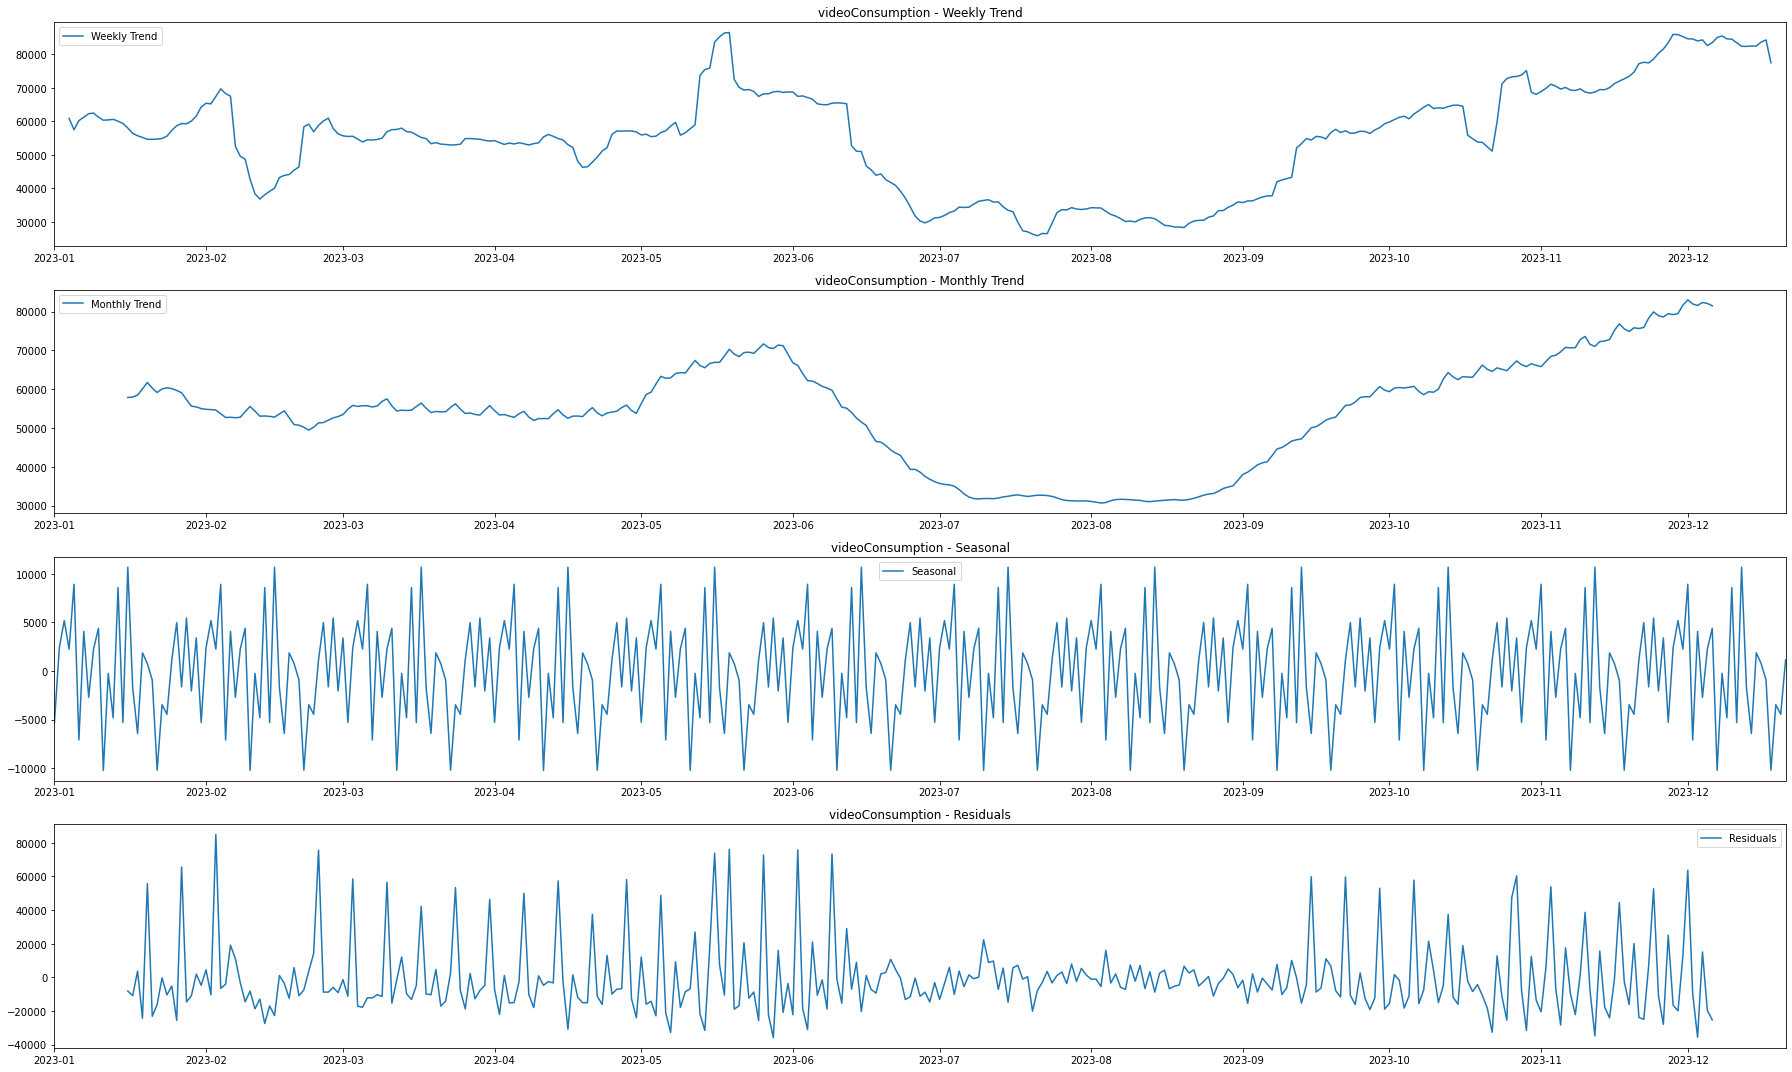

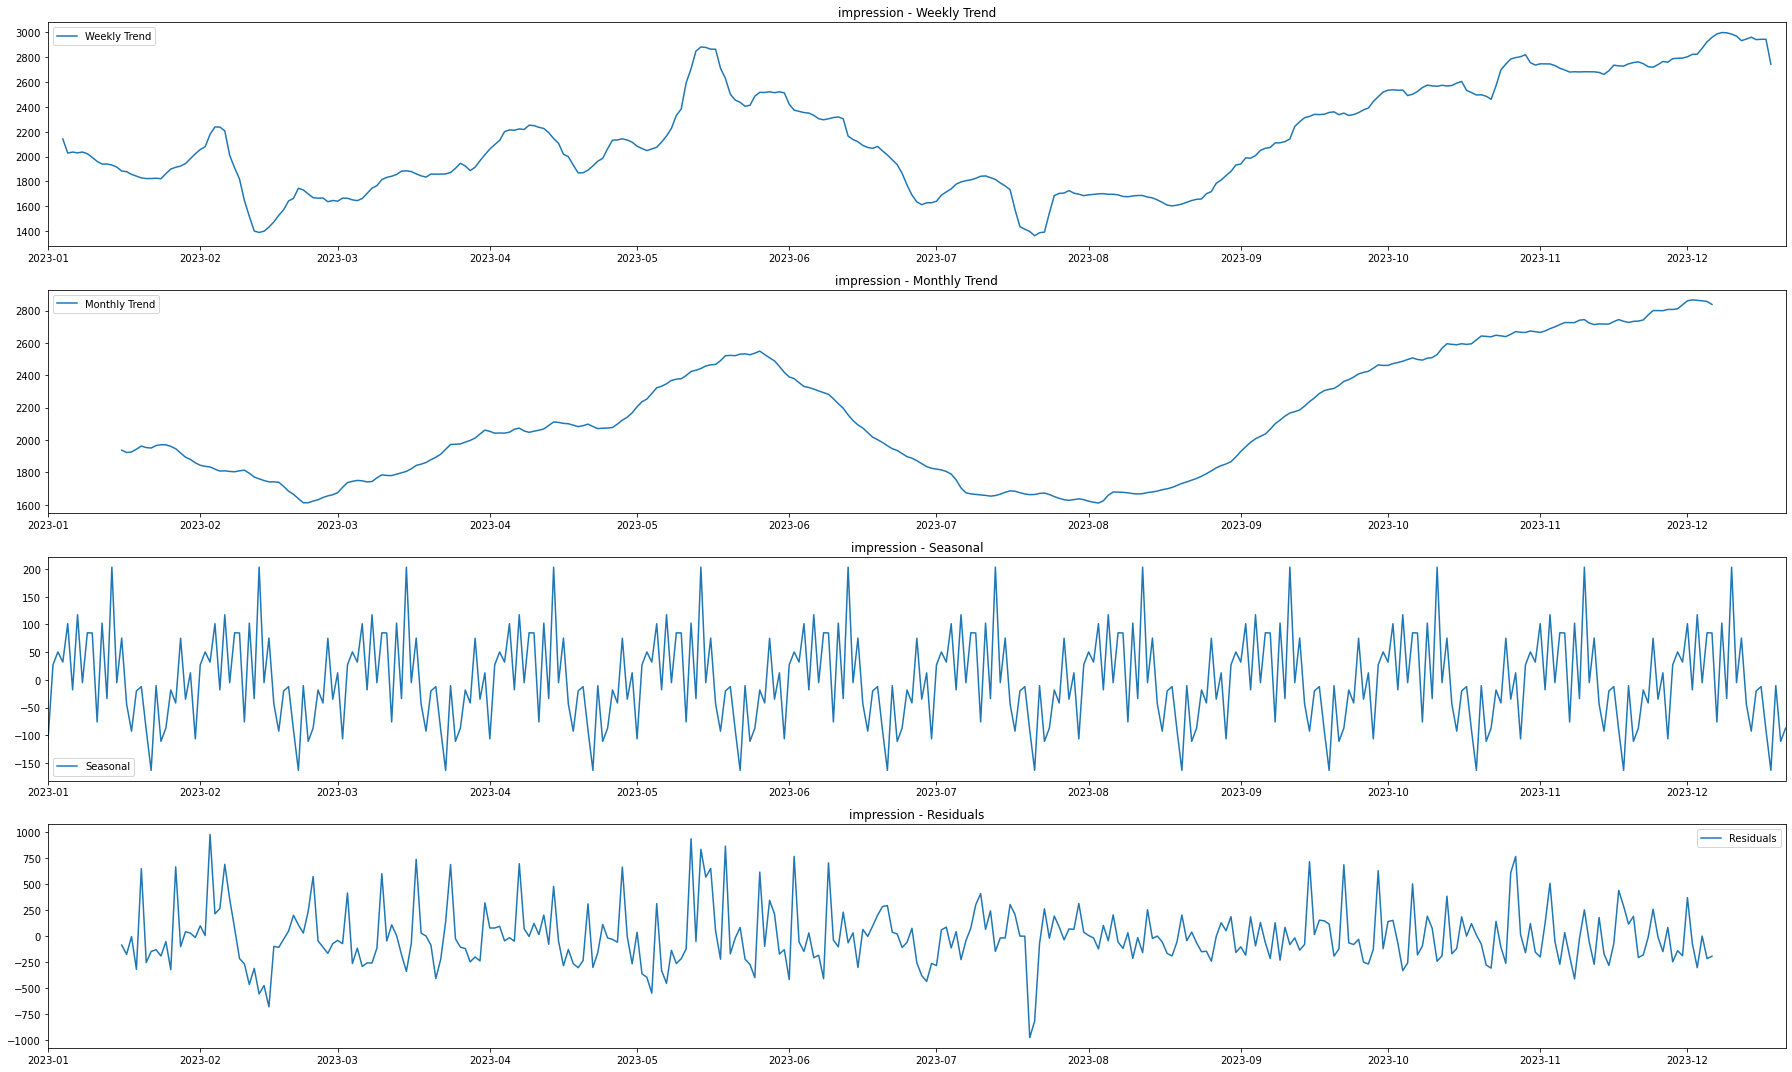

/var/folders/sk/064qrt3x6f14cz6gnn7x1d1c0000gn/T/ipykernel_2764/1617427403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day_final['date'] = pd.to_datetime(df_day_final['date'])


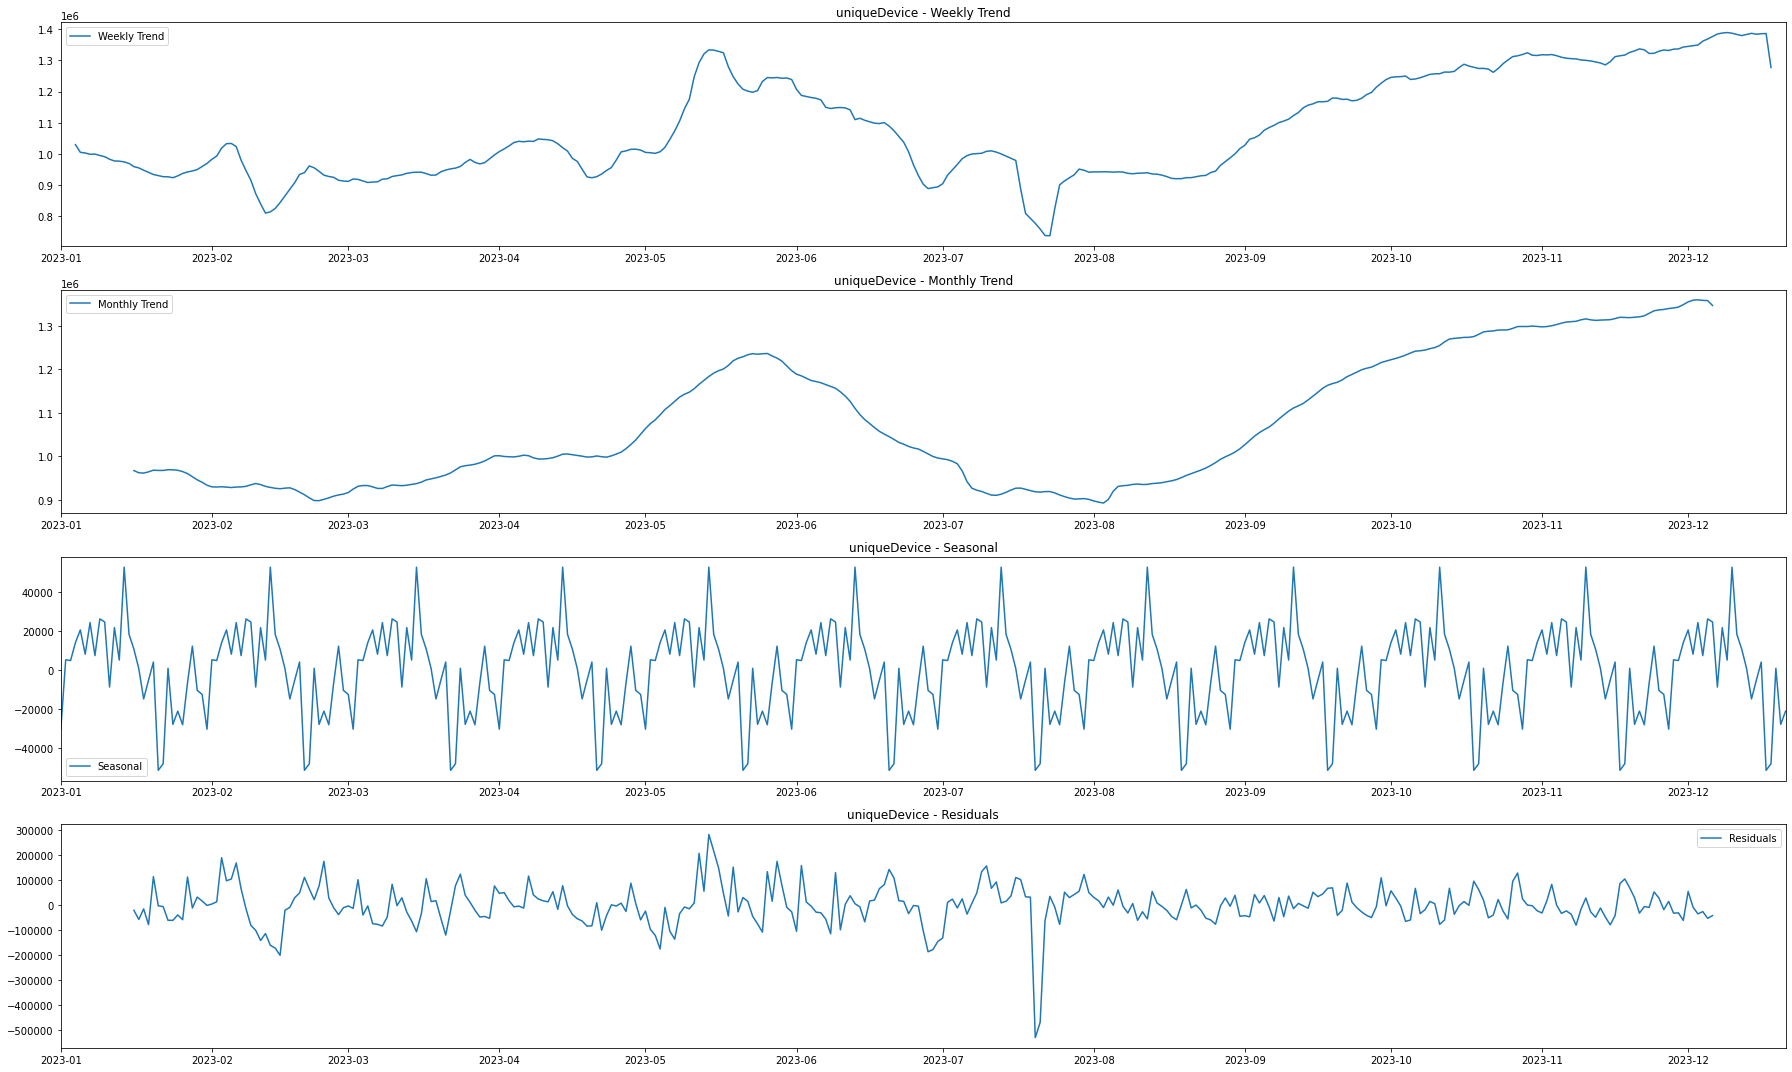

In [31]:
if not isinstance(df_minute_final.index, pd.DatetimeIndex):
    df_minute_final['datetime'] = pd.to_datetime(df_minute_final['datetime']) 
    df_minute_final.set_index('datetime', inplace=True)

# Plot videoConsumption 
plot_seasonal('videoConsumption', df_minute_final,freq='minute')

# Plot impression
plot_seasonal('impression', df_minute_final,freq='minute')

if not isinstance(df_day_final.index, pd.DatetimeIndex):
    df_day_final['date'] = pd.to_datetime(df_day_final['date'])
    df_day_final.set_index('date', inplace=True)

# Plot uniqueDevice 
plot_seasonal('uniqueDevice', df_day_final,freq='daily')


In [9]:
# Save new data frames
df_minute_final.to_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_minute_final_Star_TV.csv', index=False)
df_day_final.to_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_day_final_Star_TV.csv', index=False)

In [11]:
# Load new data frames
df_minute_final = pd.read_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_minute_final_Star_TV.csv')
df_day_final = pd.read_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_day_final_Star_TV.csv')

In [3]:
df_day_final.describe()

,uniqueDevice
count,3.550000e+02
mean,1.081609e+06
std,1.792031e+05
min,3.377060e+05
25%,9.465540e+05
50%,1.040885e+06
75%,1.230858e+06
max,1.518805e+06


In [4]:
df_minute_final.describe()

,videoConsumption,impression
count,511200.000000,511200.000000
mean,54970.398560,2142.114073
std,84269.913186,2297.568259
min,0.000000,0.000000
25%,15550.000000,650.000000
50%,35000.000000,1629.000000
75%,60503.250000,2733.000000
max,983509.000000,67240.000000


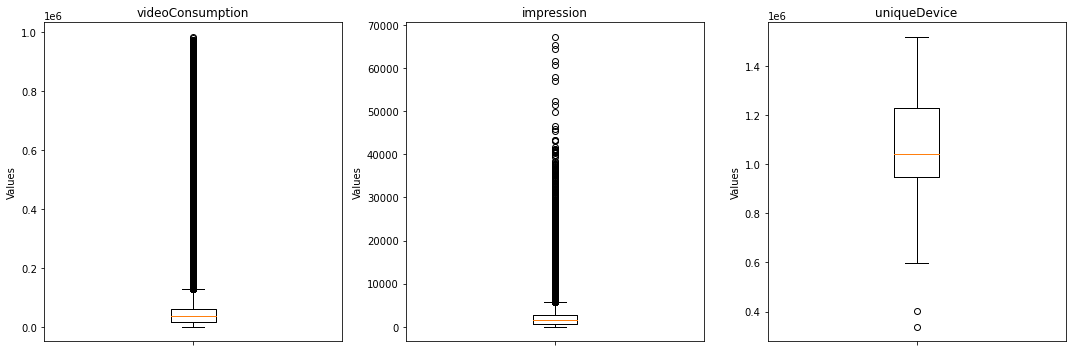

In [5]:
# Plot boxplot to see data distribution and anomalies
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

axs[0].boxplot(df_minute_final['videoConsumption'].dropna())
axs[0].set_title('videoConsumption')
axs[0].set_ylabel('Values')

axs[1].boxplot(df_minute_final['impression'].dropna())
axs[1].set_title('impression')
axs[1].set_ylabel('Values')

axs[2].boxplot(df_day_final['uniqueDevice'].dropna())
axs[2].set_title('uniqueDevice')
axs[2].set_ylabel('Values')

for ax in axs:
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

In [6]:
# Define variables for two data frame
variables_minute = ['videoConsumption', 'impression']
variables_day = ['uniqueDevice']

outlier_minute = []
outlier_day = []

# For df_minute_final
for var in variables_minute:
    Q1 = df_minute_final[var].quantile(0.25)
    Q3 = df_minute_final[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_minute_final[(df_minute_final[var] < lower_bound) | (df_minute_final[var] > upper_bound)].index
    outlier_minute.extend([element for element in outliers if element not in outlier_minute])
    print("Number of outliers in", var, ":", len(outliers), "out of", df_minute_final.shape[0])

# For df_day_final
for var in variables_day:
    Q1 = df_day_final[var].quantile(0.25)
    Q3 = df_day_final[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_day_final[(df_day_final[var] < lower_bound) | (df_day_final[var] > upper_bound)].index
    outlier_day.extend([element for element in outliers if element not in outlier_day])
    print("Number of outliers in", var, ":", len(outliers), "out of", df_day_final.shape[0])

# # Drop outliners
# df_minute_final = df_minute.drop(outlier_minute)
# df_day_final = df_day.drop(outlier_day)

Number of outliers in videoConsumption : 34008 out of 511200
Number of outliers in impression : 28696 out of 511200
Number of outliers in uniqueDevice : 2 out of 355


## 2.2 Correlation matrix  <a class="anchor" id="2.4"></a>

In [12]:
# Convert the 'datetime' column to datetime type and set it as the index
df_minute_final['datetime'] = pd.to_datetime(df_minute_final['datetime'])
df_minute_final.set_index('datetime', inplace=True)

# Convert the 'date' column to datetime type and set it as the index for df_day_final
df_day_final['date'] = pd.to_datetime(df_day_final['date'])
df_day_final.set_index('date', inplace=True)

Correlation matrix:
                  videoConsumption  impression  uniqueDevice
videoConsumption          1.000000    0.771571      0.581781
impression                0.771571    1.000000      0.943135
uniqueDevice              0.581781    0.943135      1.000000


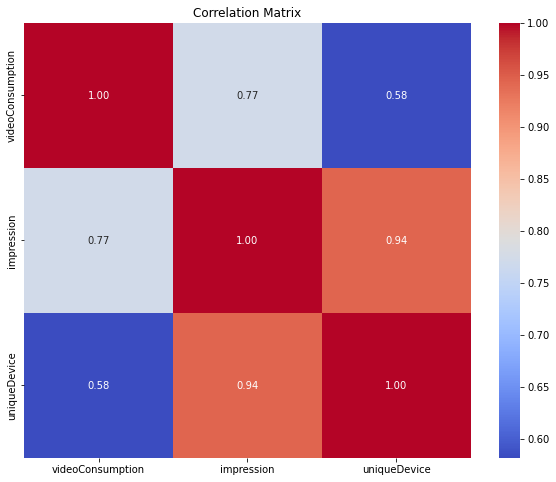

In [13]:
## Resample df_minute_final to daily data by calculating the mean of each day
df_minute_daily = df_minute_final.resample('D').mean()

# Merge the daily data from both dataframes
df_merged_d = pd.merge(df_minute_daily, df_day_final, left_index=True, right_index=True, how='inner')

# Calculate the correlation matrix for the variables of interest
correlation_matrix = df_merged_d[['videoConsumption', 'impression', 'uniqueDevice']].corr()

# Print the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Correlation matrix:
                  videoConsumption  impression  uniqueDevice
videoConsumption          1.000000    0.609251      0.192522
impression                0.609251    1.000000      0.206334
uniqueDevice              0.192522    0.206334      1.000000


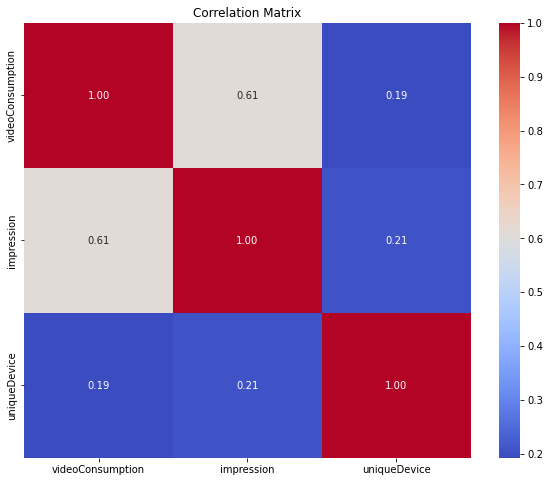

In [14]:
## Resample daily data to minute level 

# Using forward fill method
df_day_minute = df_day_final.resample('T').ffill()  # Yield to correlation uD&vC=0.17，uD&i=0.15，without NaN value.

# # Using linear interpolation method
# df_day_minute = df_day_final.resample('T').interpolate('linear') # Yield to correlation uD&vC=0.15，uD&i=0.14

# # Using spline method
# df_day_minute = df_day_final.resample('T').interpolate(method='spline', order=2) # Yield to correlation uD&vC=0.15，uD&i=0.14

# # Using mean method
# df_day_minute = df_day_final.resample('T').mean() # Yield to correlation uD&vC=0.33，uD&i=0.38

# Merge the minute data from both dataframes
df_merged_m = pd.merge(df_minute_final, df_day_minute, left_index=True, right_index=True, how='inner')

# Calculate the correlation matrix for the variables of interest
correlation_matrix = df_merged_m[['videoConsumption', 'impression', 'uniqueDevice']].corr()

# Print the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [15]:
df_merged_m.head()

,videoConsumption,impression,uniqueDevice
2023-01-01 00:00:00,129404,26624,1172313
2023-01-01 00:01:00,132429,40550,1172313
2023-01-01 00:02:00,173191,20668,1172313
2023-01-01 00:03:00,182957,20502,1172313
2023-01-01 00:04:00,186172,12067,1172313


In [16]:
# Save the merged dataframe
df_merged_m.to_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_merged_m_Star_TV.csv', index=False)
df_merged_m.reset_index().rename(columns={'index': 'datetime'}).to_csv('/Users/elynyang/Desktop/Final project/dataset/additional channels/df_merged_m_Star_TV.csv', index=False)